In [57]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
import logging
from utils.logger_utils import setup_clean_logger, mute_external_loggers

# Set up a clean logger for your notebook
logger = setup_clean_logger("notebook", logging.INFO)
logger.info("Notebook started successfully.")

# Mute logs from sisepuede to avoid duplication
mute_external_loggers(["sisepuede"])


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

2025-08-08 18:45:10,147 - INFO - Notebook started successfully.


In [58]:
# Save original path
original_sys_path = list(sys.path)

# Add the custom path
custom_path = os.path.abspath("../../data_processing/utils")
sys.path.append(custom_path)

# Import your module
import common_data_needs as cdn

# Revert to original sys.path
sys.path = original_sys_path

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initial Set up

Make sure to edit the config yaml under ssp_modeling/config_files/config.yaml

You can also create a new config yaml



In [60]:
# Set up dir paths

CURR_DIR_PATH = pathlib.Path(os.getcwd())
SSP_MODELING_DIR_PATH = CURR_DIR_PATH.parent
PROJECT_DIR_PATH = SSP_MODELING_DIR_PATH.parent
DATA_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("input_data")
RUN_OUTPUT_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("ssp_run_output")
SCENARIO_MAPPING_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("scenario_mapping")
CONFIG_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("config_files")
TRANSFORMATIONS_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("transformations")
MISC_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("misc")
STRATEGIES_DEFINITIONS_FILE_PATH = TRANSFORMATIONS_DIR_PATH.joinpath("strategy_definitions.csv")
STRATEGY_MAPPING_FILE_PATH = MISC_DIR_PATH.joinpath("strategy_mapping.yaml")

In [61]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [62]:
# Load config file, double check your parameters are correct

YAML_FILE_PATH = os.path.join(CONFIG_DIR_PATH, "config_ndc_2_tunning.yaml")
config_params = g_utils.read_yaml(YAML_FILE_PATH)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
logger.info(f"Country name: {country_name}")
logger.info(f"SSP input file name: {ssp_input_file_name}")
logger.info(f"SSP transformation CW: {ssp_transformation_cw}")
logger.info(f"Energy model flag: {energy_model_flag}")
logger.info(f"Set lndu reallocation factor to zero flag: {set_lndu_reallocation_factor_to_zero_flag}")

2025-08-08 18:45:10,206 - INFO - Country name: uganda
2025-08-08 18:45:10,207 - INFO - SSP input file name: None
2025-08-08 18:45:10,207 - INFO - SSP transformation CW: ssp_uganda_transformation_cw_ndc_2.xlsx
2025-08-08 18:45:10,207 - INFO - Energy model flag: True
2025-08-08 18:45:10,207 - INFO - Set lndu reallocation factor to zero flag: True


In [63]:
# Set up SSP objects

# INPUT_FILE_PATH = DATA_DIR_PATH.joinpath(ssp_input_file_name)

# file_struct = SISEPUEDEFileStructure()

# matt = file_struct.model_attributes
# regions = sc.Regions(matt)
# time_periods = sc.TimePeriods(matt)

dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [64]:
cdn._PATH_OUTPUTS

PosixPath('/Users/tony/Documents/sisepuede_modeling/ssp_uganda_data/data_processing/output_data')

In [65]:
df_inputs_raw = cdn._build_from_outputs(
    (
        min(time_periods.all_years),
        max(time_periods.all_years)
    ),
    fns_exclude = ["frac_lndu_initial.csv"],
    merge_type = "outer", 
    print_info = False,
    stop_on_error = True, 
)

df_inputs_raw.head()

,frac_agrc_nuts_cl1_temperate,yf_agrc_cereals_tonne_ha,frac_agrc_rice_cl2_wet,frac_agrc_cereals_cl1_tropical,frac_agrc_tubers_cl1_tropical,frac_agrc_bevs_and_spices_cl2_wet,frac_agrc_tubers_cl2_wet,frac_frst_primary_cl1_temperate_nutrient_rich,frac_lndu_grasslands_cl2_dry,yf_agrc_vegetables_and_vines_tonne_ha,...,gdp_mmm_usd,consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing,cost_enfu_fuel_biofuels_usd_per_m3,cost_enfu_fuel_crude_usd_per_m3,cost_enfu_fuel_diesel_usd_per_m3,cost_enfu_fuel_furnace_gas_usd_per_m3,cost_enfu_fuel_gasoline_usd_per_m3,cost_enfu_fuel_kerosene_usd_per_m3,cost_enfu_fuel_oil_usd_per_m3,time_period
0,0.030468,1.805033,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.002223,...,79.03,291.931267,521.090317,381.062407,1573.981481,13725.64626,1610.586420,1120.123457,541.936245,0
1,0.030468,1.832342,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.070985,...,82.81,305.894321,521.090317,381.062407,1508.786982,13725.64626,1543.875740,1073.727811,541.936245,1
2,0.030468,1.827437,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.007029,...,85.41,315.498539,521.090317,381.062407,1416.583333,13725.64626,1449.527778,1008.111111,541.936245,2
3,0.030468,1.935353,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.014348,...,90.79,335.371881,521.090317,381.062407,1397.178082,13725.64626,1429.671233,994.301370,541.936245,3
4,0.030468,2.003586,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.035314,...,96.64,356.981370,521.090317,381.062407,1380.162382,13725.64626,1412.259811,982.192152,541.936245,4


In [66]:
df_inputs_raw.tail()

,frac_agrc_nuts_cl1_temperate,yf_agrc_cereals_tonne_ha,frac_agrc_rice_cl2_wet,frac_agrc_cereals_cl1_tropical,frac_agrc_tubers_cl1_tropical,frac_agrc_bevs_and_spices_cl2_wet,frac_agrc_tubers_cl2_wet,frac_frst_primary_cl1_temperate_nutrient_rich,frac_lndu_grasslands_cl2_dry,yf_agrc_vegetables_and_vines_tonne_ha,...,gdp_mmm_usd,consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing,cost_enfu_fuel_biofuels_usd_per_m3,cost_enfu_fuel_crude_usd_per_m3,cost_enfu_fuel_diesel_usd_per_m3,cost_enfu_fuel_furnace_gas_usd_per_m3,cost_enfu_fuel_gasoline_usd_per_m3,cost_enfu_fuel_kerosene_usd_per_m3,cost_enfu_fuel_oil_usd_per_m3,time_period
51,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.030111,...,929.316458,421.17941,514.896802,376.533219,1384.476201,13562.507565,1416.673954,985.262080,535.494962,51
52,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.030111,...,947.902787,421.17941,514.763063,376.435418,1384.116597,13558.984835,1416.305986,985.006168,535.355872,52
53,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.030111,...,966.860843,421.17941,514.629358,376.337643,1383.757086,13555.463021,1415.938115,984.750322,535.216819,53
54,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.030111,...,986.198060,421.17941,514.495688,376.239893,1383.397669,13551.942122,1415.570338,984.494543,535.077801,54
55,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.030111,...,1005.922021,421.17941,514.362053,376.142168,1383.038345,13548.422137,1415.202658,984.238830,534.938820,55


In [67]:
##  BUILD BASE INPUTS
# df_inputs_raw = pd.read_csv(INPUT_FILE_PATH)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [68]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)

Columns in df_example but not in df_input: {'region'}
Columns in df_input but not in df_example: {'vec_ramp', 'iso_alpha_3'}


In [69]:
# Ensure if time_period field exist
if 'time_period' not in df_inputs_raw.columns:
    logger.info("Adding 'time_period' column to df_inputs_raw")
    df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
else:
    logger.info("'time_period' column already exists in df_inputs_raw")

2025-08-08 18:45:10,692 - INFO - 'time_period' column already exists in df_inputs_raw


In [70]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw_complete.copy())
df_inputs_raw_complete.head()

,frac_agrc_nuts_cl1_temperate,yf_agrc_cereals_tonne_ha,frac_agrc_rice_cl2_wet,frac_agrc_cereals_cl1_tropical,frac_agrc_tubers_cl1_tropical,frac_agrc_bevs_and_spices_cl2_wet,frac_agrc_tubers_cl2_wet,frac_frst_primary_cl1_temperate_nutrient_rich,frac_lndu_grasslands_cl2_dry,yf_agrc_vegetables_and_vines_tonne_ha,...,consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing,cost_enfu_fuel_biofuels_usd_per_m3,cost_enfu_fuel_crude_usd_per_m3,cost_enfu_fuel_diesel_usd_per_m3,cost_enfu_fuel_furnace_gas_usd_per_m3,cost_enfu_fuel_gasoline_usd_per_m3,cost_enfu_fuel_kerosene_usd_per_m3,cost_enfu_fuel_oil_usd_per_m3,time_period,region
0,0.030468,1.805033,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.002223,...,291.931267,521.090317,381.062407,1573.981481,13725.64626,1610.586420,1120.123457,541.936245,0,costa_rica
1,0.030468,1.832342,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.070985,...,305.894321,521.090317,381.062407,1508.786982,13725.64626,1543.875740,1073.727811,541.936245,1,costa_rica
2,0.030468,1.827437,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.007029,...,315.498539,521.090317,381.062407,1416.583333,13725.64626,1449.527778,1008.111111,541.936245,2,costa_rica
3,0.030468,1.935353,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.014348,...,335.371881,521.090317,381.062407,1397.178082,13725.64626,1429.671233,994.301370,541.936245,3,costa_rica
4,0.030468,2.003586,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,4.035314,...,356.981370,521.090317,381.062407,1380.162382,13725.64626,1412.259811,982.192152,541.936245,4,costa_rica


In [71]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: set()


In [72]:
# Check region values
df_inputs_raw_complete['region'].unique()

array(['costa_rica', nan], dtype=object)

In [73]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].unique()

array(['uganda'], dtype=object)

## Let's Modify the  LNDU Reallocation factor

In [74]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

np.float64(0.0)

In [75]:
# Get fields with nulls
fields_with_nulls = df_inputs_raw_complete.columns[df_inputs_raw_complete.isnull().any()].tolist()
fields_with_nulls

[]

In [76]:
df_inputs_raw_complete.shape

(56, 2380)

#  Let's try building transformations using this


In [77]:
transformers = trf.transformers.Transformers(
    {},
    attr_time_period = cdn._ATTRIBUTE_TABLE_TIME_PERIOD,
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [78]:
# set an ouput path and instantiate
if not TRANSFORMATIONS_DIR_PATH.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        TRANSFORMATIONS_DIR_PATH,
    )
else:
    logger.info(f"Directory {TRANSFORMATIONS_DIR_PATH} already exists. Skipping instantiation.")


2025-08-08 18:45:11,170 - INFO - Directory /Users/tony/Documents/sisepuede_modeling/ssp_uganda_data/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [79]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

if ssp_transformation_cw is None:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")
else:
    logger.info(f"Using transformation file: {ssp_transformation_cw}")
    cw_file_path = os.path.join(SCENARIO_MAPPING_DIR_PATH, ssp_transformation_cw)
    logger.info(f"Transformation file path: {cw_file_path}")
    excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=TRANSFORMATIONS_DIR_PATH)

2025-08-08 18:45:11,182 - INFO - Using transformation file: ssp_uganda_transformation_cw_ndc_2.xlsx
2025-08-08 18:45:11,183 - INFO - Transformation file path: /Users/tony/Documents/sisepuede_modeling/ssp_uganda_data/ssp_modeling/scenario_mapping/ssp_uganda_transformation_cw_ndc_2.xlsx


In [80]:
# This creates transformation yaml files for each strategy in the excel file
if ssp_transformation_cw is not None:
    logger.info("Processing YAML files...")
    excel_yaml_handler.process_yaml_files()
else:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")

2025-08-08 18:45:11,211 - INFO - Processing YAML files...


[transformation_agrc_inc_conservation_agriculture.yaml | TX:AGRC:INC_CONSERVATION_AGRICULTURE] Expand conservation agriculture (AGRC) | Start: 5
Strategy: strategy_NDC_2, Scalar value: 1.0
YAML file transformation_agrc_inc_conservation_agriculture.yaml already exists for strategy strategy_NDC_2. Please check manually.
[transformation_agrc_inc_productivity.yaml | TX:AGRC:INC_PRODUCTIVITY] Improve crop productivity (AGRC) | Start: 5
Strategy: strategy_NDC_2, Scalar value: 1.0
[transformation_entc_dec_losses.yaml | TX:ENTC:DEC_LOSSES] Reduce transmission losses (ENTC) | Start: 5
Strategy: strategy_NDC_2, Scalar value: 1.0
[transformation_entc_target_renewable_elec.yaml | TX:ENTC:TARGET_RENEWABLE_ELEC] 95% of electricity is generated by renewables in 2050 (ENTC) | Start: 5
Strategy: strategy_NDC_2, Scalar value: 1.0
[transformation_inen_inc_efficiency_energy.yaml | TX:INEN:INC_EFFICIENCY_ENERGY] Maximize industrial energy efficiency (INEN) | Start: 5
Strategy: strategy_NDC_2, Scalar value:

In [81]:
# Temporary fix to add a parameter to the yaml files
from ruamel.yaml import YAML
yaml = YAML()
# tell it to keep your original quoting
yaml.preserve_quotes = True

def add_parameter_to_yaml_files(transformation_folder_path, yaml_files, n_tp_ramp=15):
    for fn in yaml_files:
        path = os.path.join(transformation_folder_path, fn)
        with open(path, 'r') as f:
            data = yaml.load(f)              # <-- ruamel.yaml keeps your formatting
            
        if 'parameters' not in data:
            raise ValueError(f"{fn!r} has no ‘parameters’ key")
        
        if 'vec_implementation_ramp' not in data['parameters']:
            raise ValueError(f"{fn!r} has no ‘vec_implementation_ramp’ key")
        
        # Assuming you want to add a key-value pair inside `vec_implementation_ramp`
        if data['parameters']['vec_implementation_ramp'] is None:
            data['parameters']['vec_implementation_ramp'] = {}  # initialize as dict if None

        data['parameters']['vec_implementation_ramp']["n_tp_ramp"] = n_tp_ramp # add your key
    
        with open(path, 'w') as f:
            yaml.dump(data, f)               # <-- dumps with the *same* quotes, indents, folds

# usage
# prefix = "transformation_waso"
# yaml_files_with_prefix = [f for f in os.listdir(TRANSFORMATIONS_DIR_PATH)
#                           if f.startswith(prefix) and f.endswith('.yaml')]

yaml_files_with_prefix = ["transformation_lndu_dec_deforestation_strategy_NDC_2.yaml", 
                          "transformation_lndu_inc_reforestation_strategy_NDC_2.yaml",
                          "transformation_agrc_inc_conservation_agriculture_strategy_NDC_2.yaml",
                          "transformation_agrc_inc_productivity_strategy_NDC_2.yaml",
                          "transformation_lvst_dec_enteric_fermentation_strategy_NDC_2.yaml",
                          "transformation_lvst_inc_productivity_strategy_NDC_2.yaml"
                          ]

energy_yaml_files_with_prefix = ["transformation_inen_inc_efficiency_energy_strategy_NDC_2.yaml",
                                 "transformation_inen_inc_efficiency_production_strategy_NDC_2.yaml",
                                 "transformation_scoe_dec_demand_heat_strategy_NDC_2.yaml"]



add_parameter_to_yaml_files(TRANSFORMATIONS_DIR_PATH, yaml_files_with_prefix, n_tp_ramp=10)
# add_parameter_to_yaml_files(TRANSFORMATIONS_DIR_PATH, energy_yaml_files_with_prefix, n_tp_ramp=45)


In [82]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct

if ssp_transformation_cw is not None:
    logger.info("Loading transformations per strategy dictionary...")
    transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
    transformation_per_strategy_dict
    logger.info(f"Loaded transformations for strategies: {transformation_per_strategy_dict.keys()}")
else:
    logger.warning("No transformation handler available. Please check your config file.")

2025-08-08 18:45:11,263 - INFO - Loading transformations per strategy dictionary...
2025-08-08 18:45:11,264 - INFO - Loaded transformations for strategies: dict_keys(['strategy_NDC_2'])


### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [83]:
# Creating new strategies by updating the strategy_definitions file.

if ssp_transformation_cw is not None:
    # You can edit this to add yours, as many as you want.
    csv_handler = StrategyCSVHandler(csv_file_path=STRATEGIES_DEFINITIONS_FILE_PATH, 
                                     yaml_dir_path=TRANSFORMATIONS_DIR_PATH, 
                                     yaml_mapping_file=STRATEGY_MAPPING_FILE_PATH, 
                                     transformation_per_strategy_dict=transformation_per_strategy_dict)
    
    for strategy_name in transformation_per_strategy_dict.keys():
        yaml_file_suffix = strategy_name.split('strategy_')[-1]
        csv_handler.add_strategy(strategy_group='PFLO', description='Custom Strategy', yaml_file_suffix=yaml_file_suffix)

else:
    logger.warning("No transformation handler available. Please check your config file.")


INFO: Strategy code PFLO:NDC_2 already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC_2


In [84]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6006]
logger.info(f"Strategies to run: {strategies_to_run}")

2025-08-08 18:45:11,301 - INFO - Strategies to run: [0, 6006]


### We finished adding new transformation files and strategies so lets load them back

In [85]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    TRANSFORMATIONS_DIR_PATH,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [86]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
logger.info(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

2025-08-08 18:45:13,944 - INFO - Strategies defined at /Users/tony/Documents/sisepuede_modeling/ssp_uganda_data/ssp_modeling/transformations initialized in 2.53 seconds


In [87]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
69,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
70,6003,PFLO:NDC,NDC,NDC Pathway,TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_NDC|TX...,0
71,6004,PFLO:NZ,NZ,Custom Strategy,TX:WASO:INC_LANDFILLING_STRATEGY_NZ|TX:LSMM:IN...,0
72,6005,PFLO:BAU,BAU,Custom Strategy,TX:AGRC:INC_PRODUCTIVITY_STRATEGY_BAU|TX:LVST:...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [88]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
# df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    # df_trajgroup = df_vargroups,
    # include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [89]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    #id_str = f"sisepuede_run_2025-07-28T12:30:52.790396",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    # try_exogenous_xl_types_in_variable_specification = True,
    attribute_time_period = cdn._ATTRIBUTE_TABLE_TIME_PERIOD
)

2025-08-08 18:45:16,538 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-08 18:45:16,538 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-08 18:45:16,539 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-08 18:45:16,539 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-08 18:45:16,539 - INFO - 	Setting export engine to 'csv'.
2025-08-08 18:45:16,539 - INFO - 	Setting export engine to 'csv'.
2025-08-08 18:45:16,540 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-08 18:45:16,540 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-08 18:45:16,540 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-08-08 18:45:16,540 - INFO - Successfully

yay


2025-08-08 18:45:17,060 - INFO - Initializing FutureTrajectories
2025-08-08 18:45:17,060 - INFO - Initializing FutureTrajectories
2025-08-08 18:45:18,690 - INFO - Instantiating 1738 sampling units.
2025-08-08 18:45:18,690 - INFO - Instantiating 1738 sampling units.
2025-08-08 18:45:18,698 - INFO - Iteration 0 complete.
2025-08-08 18:45:18,698 - INFO - Iteration 0 complete.
2025-08-08 18:45:21,051 - INFO - Iteration 250 complete.
2025-08-08 18:45:21,051 - INFO - Iteration 250 complete.
2025-08-08 18:45:22,510 - INFO - Iteration 500 complete.
2025-08-08 18:45:22,510 - INFO - Iteration 500 complete.
2025-08-08 18:45:23,897 - INFO - Iteration 750 complete.
2025-08-08 18:45:23,897 - INFO - Iteration 750 complete.
2025-08-08 18:45:25,508 - INFO - Iteration 1000 complete.
2025-08-08 18:45:25,508 - INFO - Iteration 1000 complete.
2025-08-08 18:45:26,926 - INFO - Iteration 1250 complete.
2025-08-08 18:45:26,926 - INFO - Iteration 1250 complete.
2025-08-08 18:45:28,328 - INFO - Iteration 1500 co

In [90]:
df_baseline = strategies.get_strategy(0)
df_baseline = df_baseline()
df_baseline.tail()

,strategy_id,frac_agrc_nuts_cl1_temperate,yf_agrc_cereals_tonne_ha,frac_agrc_rice_cl2_wet,frac_agrc_cereals_cl1_tropical,frac_agrc_tubers_cl1_tropical,frac_agrc_bevs_and_spices_cl2_wet,frac_agrc_tubers_cl2_wet,frac_frst_primary_cl1_temperate_nutrient_rich,frac_lndu_grasslands_cl2_dry,...,consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing,cost_enfu_fuel_biofuels_usd_per_m3,cost_enfu_fuel_crude_usd_per_m3,cost_enfu_fuel_diesel_usd_per_m3,cost_enfu_fuel_furnace_gas_usd_per_m3,cost_enfu_fuel_gasoline_usd_per_m3,cost_enfu_fuel_kerosene_usd_per_m3,cost_enfu_fuel_oil_usd_per_m3,time_period,region
51,0,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.896802,376.533219,1384.476201,13562.507565,1416.673954,985.262080,535.494962,51,uganda
52,0,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.763063,376.435418,1384.116597,13558.984835,1416.305986,985.006168,535.355872,52,uganda
53,0,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.629358,376.337643,1383.757086,13555.463021,1415.938115,984.750322,535.216819,53,uganda
54,0,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.495688,376.239893,1383.397669,13551.942122,1415.570338,984.494543,535.077801,54,uganda
55,0,0.030468,1.799328,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.362053,376.142168,1383.038345,13548.422137,1415.202658,984.238830,534.938820,55,uganda


In [91]:
df_strategy = strategies.get_strategy(6006)
df_strategy = df_strategy()
df_strategy.tail()

,strategy_id,frac_agrc_nuts_cl1_temperate,yf_agrc_cereals_tonne_ha,frac_agrc_rice_cl2_wet,frac_agrc_cereals_cl1_tropical,frac_agrc_tubers_cl1_tropical,frac_agrc_bevs_and_spices_cl2_wet,frac_agrc_tubers_cl2_wet,frac_frst_primary_cl1_temperate_nutrient_rich,frac_lndu_grasslands_cl2_dry,...,consumpinit_inen_energy_tj_per_mmm_gdp_other_product_manufacturing,cost_enfu_fuel_biofuels_usd_per_m3,cost_enfu_fuel_crude_usd_per_m3,cost_enfu_fuel_diesel_usd_per_m3,cost_enfu_fuel_furnace_gas_usd_per_m3,cost_enfu_fuel_gasoline_usd_per_m3,cost_enfu_fuel_kerosene_usd_per_m3,cost_enfu_fuel_oil_usd_per_m3,time_period,region
51,6006,0.030468,2.159194,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.896802,376.533219,1384.476201,13562.507565,1416.673954,985.262080,535.494962,51,uganda
52,6006,0.030468,2.159194,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.763063,376.435418,1384.116597,13558.984835,1416.305986,985.006168,535.355872,52,uganda
53,6006,0.030468,2.159194,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.629358,376.337643,1383.757086,13555.463021,1415.938115,984.750322,535.216819,53,uganda
54,6006,0.030468,2.159194,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.495688,376.239893,1383.397669,13551.942122,1415.570338,984.494543,535.077801,54,uganda
55,6006,0.030468,2.159194,0.988021,0.969532,0.969532,0.988021,0.988021,0.015234,0.011979,...,421.17941,514.362053,376.142168,1383.038345,13548.422137,1415.202658,984.238830,534.938820,55,uganda


In [92]:
df_out_baseline = ssp.models.project(df_input_data=df_baseline,
                   time_periods_run=list(range(16)))

df_out_strategy = ssp.models.project(df_input_data=df_strategy,
                   time_periods_run=list(range(16)))


2025-08-08 18:45:29,984 - INFO - Running AFOLU model
2025-08-08 18:45:29,984 - INFO - Running AFOLU model
2025-08-08 18:45:30,096 - INFO - AFOLU model run successfully completed
2025-08-08 18:45:30,096 - INFO - AFOLU model run successfully completed
2025-08-08 18:45:30,096 - INFO - Running CircularEconomy model
2025-08-08 18:45:30,096 - INFO - Running CircularEconomy model
2025-08-08 18:45:30,118 - INFO - CircularEconomy model run successfully completed
2025-08-08 18:45:30,118 - INFO - CircularEconomy model run successfully completed
2025-08-08 18:45:30,118 - INFO - Running IPPU model
2025-08-08 18:45:30,118 - INFO - Running IPPU model
2025-08-08 18:45:30,150 - INFO - IPPU model run successfully completed
2025-08-08 18:45:30,150 - INFO - IPPU model run successfully completed
2025-08-08 18:45:30,151 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-08 18:45:30,151 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-08 1

2025-08-Aug 18:45:30.403 Opened SQLite database at /opt/miniconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-08-Aug 18:45:30.411 Added NEMO structure to SQLite database at /opt/miniconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-08-Aug 18:45:30.945 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2025-08-Aug 18:45:44.838 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-08 18:45:44,921 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-08 18:45:44,921 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-08 18:45:44,928 - INFO - EnergyProduction model run successfully completed
2025-08-08 18:45:44,928 - INFO - EnergyProduction model run successfully completed
2025-08-08 18:45:44,929 - INFO - Running Energy (Fugitive Emissions)
2025-08-08 18:45:44,929 - INFO - Running Energy (Fugitive Emissions)
2025-08-08 18:45:44,949 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-08 18:45:44,949 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-08 18:45:44,949 - INFO - Appending Socioeconomic outputs
2025-08-08 18:45:44,949 - INFO - Appending Socioec

2025-08-Aug 18:45:45.915 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-08 18:45:57,666 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-08 18:45:57,666 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-08 18:45:57,672 - INFO - EnergyProduction model run successfully completed
2025-08-08 18:45:57,672 - INFO - EnergyProduction model run successfully completed
2025-08-08 18:45:57,672 - INFO - Running Energy (Fugitive Emissions)
2025-08-08 18:45:57,672 - INFO - Running Energy (Fugitive Emissions)
2025-08-08 18:45:57,692 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-08 18:45:57,692 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-08 18:45:57,693 - INFO - Appending Socioeconomic outputs
2025-08-08 18:45:57,693 - INFO - Appending Socioec

2025-08-Aug 18:45:57.597 Finished modeling scenario.


In [93]:
# not(energy_model_flag)

In [94]:
# # This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
# dict_scens = {
#     ssp.key_design: [0],
#     ssp.key_future: [0],
#     ssp.key_strategy: strategies_to_run,
# }

# ssp.project_scenarios(
#     dict_scens,
#     save_inputs = True,
#     include_electricity_in_energy = energy_model_flag
# )

In [95]:
# # Read input and output files
# df_out = ssp.read_output(None)
# df_in = ssp.read_input(None)

In [96]:
# df_out.head()

In [97]:
def plot_field_stack(
    df,
    fields,
    dict_format,
    time_col="time_period",
    primary_id=None,
    figsize=(18, 8),
    legend_loc='upper right',
    legend_bbox=(1.1, 1),
    ylabel="MT Emissions CO2e",
    xlabel="Time Period",
    title=None,
):
    """
    Plots a stack plot of the selected fields for a given primary_id.

    Args:
        df (pd.DataFrame): DataFrame containing output data.
        fields (list): List of column names to plot.
        dict_format (dict): Formatting dictionary for colors.
        time_col (str): Name of the time column.
        primary_id (int): Value of primary_id to filter.
        figsize (tuple): Figure size.
        legend_loc (str): Legend location.
        legend_bbox (tuple): Legend bbox_to_anchor.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    if primary_id is not None:
        df_plot = df[df[ssp.key_primary].isin([primary_id])]
    else:
        df_plot = df

    fig, ax = spu.plot_stack(
        df_plot,
        fields,
        dict_formatting=dict_format,
        field_x=time_col,
        figtuple=(fig, ax),
    )

    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, title="Fields")
    plt.show()

In [98]:
# Define the fields to plot and the formatting dictionary
subsector_emission_fields = matt.get_all_subsector_emission_total_fields()

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

In [99]:
# run_primary_ids = df_out.primary_id.unique()
# run_primary_ids

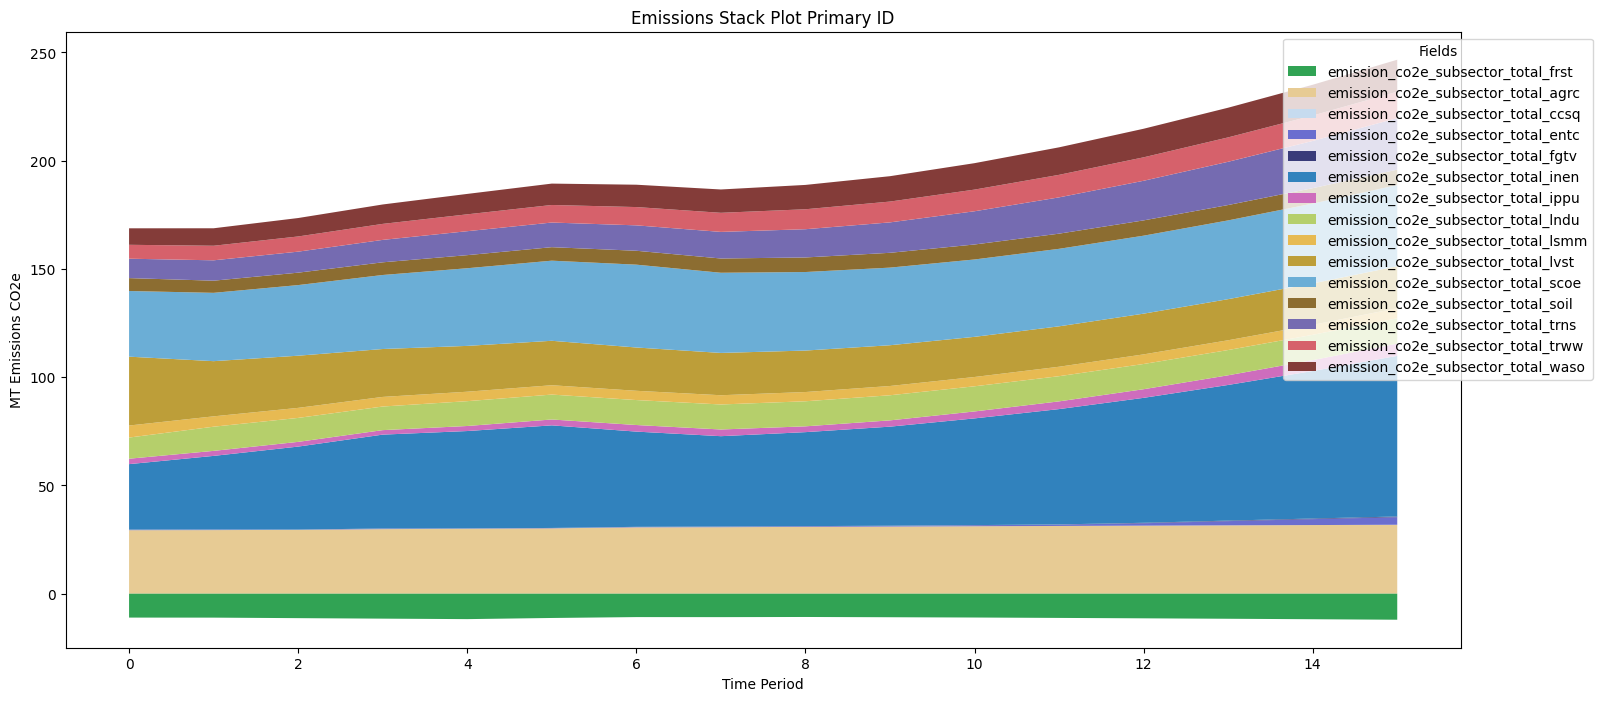

In [100]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)

plot_field_stack(
    df_out_baseline,
    subsector_emission_fields,
    dict_format,
    title=f"Emissions Stack Plot Primary ID"
)

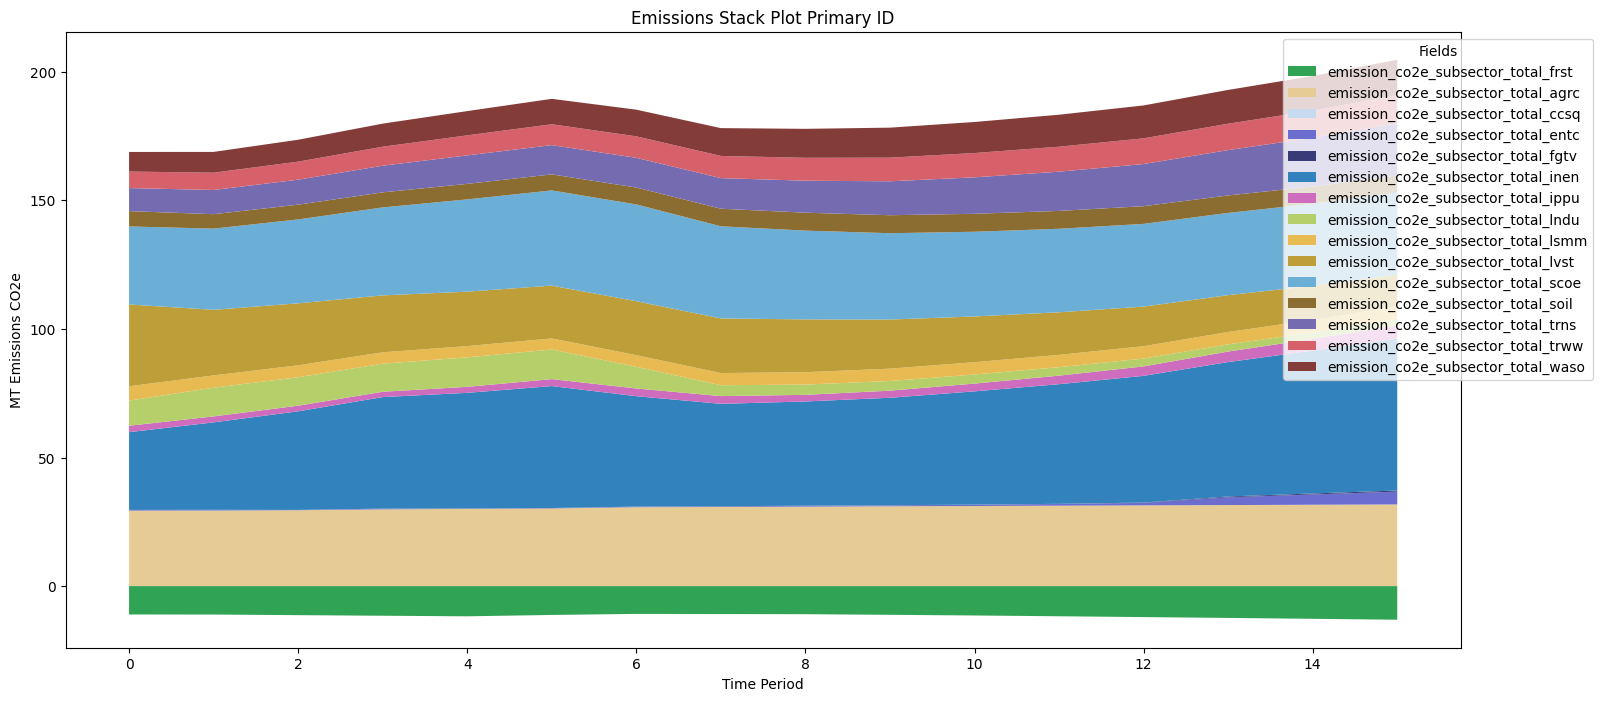

In [101]:
plot_field_stack(
    df_out_strategy,
    subsector_emission_fields,
    dict_format,
    title=f"Emissions Stack Plot Primary ID"
)

## Evaluate mitigation against baseline

In [102]:
subsector_emission_fields

['emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil',
 'emission_co2e_subsector_total_waso',
 'emission_co2e_subsector_total_trww',
 'emission_co2e_subsector_total_ccsq',
 'emission_co2e_subsector_total_entc',
 'emission_co2e_subsector_total_fgtv',
 'emission_co2e_subsector_total_inen',
 'emission_co2e_subsector_total_scoe',
 'emission_co2e_subsector_total_trns',
 'emission_co2e_subsector_total_ippu']

In [103]:

def filter_and_sum_emissions(df, time_period, emission_fields):
    """
    Filter the DataFrame for a specific time period, sum emissions across specified fields,
    and drop those fields from the result.

    Args:
        df (pd.DataFrame): Input DataFrame.
        time_period (int): Time period to filter on.
        emission_fields (list): List of emission field names to sum.

    Returns:
        pd.DataFrame: Filtered DataFrame with 'total_emissions' column.
    """

    afolu_fields = [
        "emission_co2e_subsector_total_agrc",
        "emission_co2e_subsector_total_frst",
        "emission_co2e_subsector_total_lndu",
        "emission_co2e_subsector_total_lsmm",
        "emission_co2e_subsector_total_lvst",
        "emission_co2e_subsector_total_soil",    
        ]
    
    energy_fields = [
        "emission_co2e_subsector_total_entc",
        "emission_co2e_subsector_total_scoe",
        "emission_co2e_subsector_total_inen",
        "emission_co2e_subsector_total_fgtv",
        "emission_co2e_subsector_total_ccsq",
    ]

    waste_fields = [
        "emission_co2e_subsector_total_waso",
        "emission_co2e_subsector_total_trww",
    ]

    transport_fields = [
        "emission_co2e_subsector_total_trns",
    ]

    ippu_fields = [
        "emission_co2e_subsector_total_ippu",
    ]

    df_filtered = df[df['time_period'] == time_period].reset_index(drop=True)
    df_filtered = df_filtered[emission_fields]
    df_filtered['total_emissions'] = df_filtered[emission_fields].sum(axis=1)
    df_filtered['afolu_emissions'] = df_filtered[afolu_fields].sum(axis=1)
    df_filtered['energy_emissions'] = df_filtered[energy_fields].sum(axis=1)
    df_filtered['waste_emissions'] = df_filtered[waste_fields].sum(axis=1)
    df_filtered['transport_emissions'] = df_filtered[transport_fields].sum(axis=1)
    df_filtered['ippu_emissions'] = df_filtered[ippu_fields].sum(axis=1)

    df_filtered = df_filtered.drop(columns=emission_fields)
    return df_filtered

# Example usage:
# df_out_filtered = filter_and_sum_emissions(df_out_baseline, 15, subsector_emission_fields)
# df_out_filtered.head()

In [104]:
df_out_baseline_filtered = filter_and_sum_emissions(df_out_baseline, 15, subsector_emission_fields)
df_out_strategy_filtered = filter_and_sum_emissions(df_out_strategy, 15, subsector_emission_fields)

In [105]:
df_out_baseline_filtered.head()

,total_emissions,afolu_emissions,energy_emissions,waste_emissions,transport_emissions,ippu_emissions
0,234.626209,62.696874,115.504568,26.96285,23.80561,5.656306


In [106]:
df_out_strategy_filtered

,total_emissions,afolu_emissions,energy_emissions,waste_emissions,transport_emissions,ippu_emissions
0,191.566765,45.036927,96.454882,24.628645,20.369423,5.076889


In [107]:
# Calculate mitigation for each column
mitigation = df_out_baseline_filtered.iloc[0] - df_out_strategy_filtered.iloc[0]

# Build comparison table
comparison = pd.DataFrame({
    'Baseline Emissions': df_out_baseline_filtered.iloc[0],
    'Strategy Emissions': df_out_strategy_filtered.iloc[0],
    'Mitigation': mitigation
})

# Optional: round for neatness
comparison = comparison.round(3)

comparison

,Baseline Emissions,Strategy Emissions,Mitigation
total_emissions,234.626,191.567,43.059
afolu_emissions,62.697,45.037,17.660
energy_emissions,115.505,96.455,19.050
waste_emissions,26.963,24.629,2.334
transport_emissions,23.806,20.369,3.436
ippu_emissions,5.656,5.077,0.579


In [108]:
# NOTE: Temporal fix to save the output files
OUTPUT_FOLDER_PATH = RUN_OUTPUT_DIR_PATH.joinpath(ssp.id_fs_safe)
os.makedirs(OUTPUT_FOLDER_PATH, exist_ok=True)
logger.info(f"Output folder created at: {OUTPUT_FOLDER_PATH}")

2025-08-08 18:45:58,380 - INFO - Output folder created at: /Users/tony/Documents/sisepuede_modeling/ssp_uganda_data/ssp_modeling/ssp_run_output/sisepuede_run_2025-08-08T18;45;16.252055


In [109]:
df_out_baseline.to_csv(OUTPUT_FOLDER_PATH.joinpath("df_out_baseline.csv"), index=False)
df_out_strategy.to_csv(OUTPUT_FOLDER_PATH.joinpath("df_out_strategy.csv"), index=False)

# Export Wide File (Last Mandatory Step)

In [110]:
# all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# # build if unable to simply read the data frame
# if df_in is None:
#     df_in = []
     
#     for region in ssp.regions:
#         for primary in all_primaries: 
#             df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
#             df_in.append(df_in_filt.get(region))
    
#     df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




# df_export = pd.merge(
#     df_out,
#     df_in,
#     how = "left",
# )



# # check output directory 
# dir_pkg = os.path.join(
#     ssp.file_struct.dir_out, 
#     f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
# )
# os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


# for tab in ["ATTRIBUTE_STRATEGY"]:
#     table_df = ssp.database.db.read_table(tab)
#     if table_df is not None:
#         table_df.to_csv(
#             os.path.join(dir_pkg, f"{tab}.csv"),
#             index=None,
#             encoding="UTF-8"
#         )
#     else:
#         print(f"Warning: Table {tab} returned None.")


# df_primary = (
#     ssp
#     .odpt_primary
#     .get_indexing_dataframe(
#         sorted(list(df_out[ssp.key_primary].unique()))
#     )
# )
    
# df_primary.to_csv(
#     os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
#     index = None,
#     encoding = "UTF-8"
# )

# df_export.to_csv(
#     os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
#     index = None,
#     encoding = "UTF-8"
# )

In [111]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/opt/miniconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/out'

In [112]:
# RUN_ID_OUTPUT_DIR_PATH = os.path.join(
#     RUN_OUTPUT_DIR_PATH, 
#     ssp.id_fs_safe
# )

# os.makedirs(RUN_ID_OUTPUT_DIR_PATH, exist_ok=True)

# df_primary.to_csv(
#     os.path.join(RUN_ID_OUTPUT_DIR_PATH, "ATTRIBUTE_PRIMARY.csv"),
#     index = None,
#     encoding = "UTF-8"
# )

# df_export.to_csv(

    
#     os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{ssp.id_fs_safe}.csv"),
#     index = None,
#     encoding = "UTF-8"
# )

# for tab in ["ATTRIBUTE_STRATEGY"]:
#     table_df = ssp.database.db.read_table(tab)
#     if table_df is not None:
#         table_df.to_csv(
#             os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{tab}.csv"),
#             index=None,
#             encoding="UTF-8"
#         )
#     else:
#         logger.warning(f"Warning: Table {tab} returned None.")